In [ ]:
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
!pip install Theano

     |████████████████████████████████| 235kB 389kB/s 
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp27-none-any.whl size=122797 sha256=4a50ce0e76cb3e5fe00195f62dcb2a14e71ccc1282aa8ba8dd876fa05ee4d932
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0qRSt/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne


#**Utils**

In [ ]:
import numpy as np
from sklearn import utils as skutils
from PIL import Image
# from rng import np_rng, py_rng

def list_shuffle(*data):
    idxs = np_rng.permutation(np.arange(len(data[0])))
    if len(data) == 1:
        return [data[0][idx] for idx in idxs]
    else:
        return [[d[idx] for idx in idxs] for d in data]

def shuffle(*arrays, **options):
    if isinstance(arrays[0][0], basestring):
        return list_shuffle(*arrays)
    else:
        return skutils.shuffle(*arrays, random_state=np_rng)

def iter_data(*data, **kwargs):
    size = kwargs.get('size', 128)
    try:
        n = len(data[0])
    except:
        n = data[0].shape[0]
    batches = n / size
    if n % size != 0:
        batches += 1

    for b in range(batches):
        start = b * size
        end = (b + 1) * size
        if end > n:
            end = n
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])


def ImgRescale(img,center=True,scale=True, convert_back=False):
    img = np.array(img)
    img = np.cast['float64'](img)
    if center and scale:
        img = ((img+1) / 2 * 255).astype(np.uint8) 
    elif center:
	img = (img + 127.5).astype(np.uint8) 
    elif scale:
	img = (img * 255).astype(np.uint8) 
    return img

In [ ]:
from numpy.random import RandomState
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from random import Random

seed = 42

py_rng = Random(seed)
np_rng = RandomState(seed)
t_rng = RandomStreams(seed)

def set_seed(n):
    global seed, py_rng, np_rng, t_rng
    
    seed = n
    py_rng = Random(seed)
    np_rng = RandomState(seed)
    t_rng = RandomStreams(seed)

In [ ]:
import numpy as np
import theano

def intX(X):
    return np.asarray(X, dtype=np.int32)

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def sharedX(X, dtype=theano.config.floatX, name=None):
    return theano.shared(np.asarray(X, dtype=dtype), name=name)

def shared0s(shape, dtype=theano.config.floatX, name=None):
    return sharedX(np.zeros(shape), dtype=dtype, name=name)

def sharedNs(shape, n, dtype=theano.config.floatX, name=None):
    return sharedX(np.ones(shape)*n, dtype=dtype, name=name)

In [ ]:
def xavier_init(size_data):
    in_dim = size_data[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return np.random.normal(scale=xavier_stddev, size=size_data).astype("float64")

#**Build Network**

In [ ]:
from lasagne.layers import InputLayer, ReshapeLayer, DenseLayer, batch_norm, DropoutLayer, Deconv2DLayer, BatchNormLayer, NonlinearityLayer, ElemwiseSumLayer, ConcatLayer, FlattenLayer, Pool2DLayer, Upscale2DLayer
from lasagne.nonlinearities import sigmoid, LeakyRectify, sigmoid, tanh, softmax, elu
from lasagne.nonlinearities import rectify as relu
from lasagne.layers import Conv2DLayer
from theano.tensor import TensorType
from lasagne.init import Normal, HeNormal
import theano
from theano import tensor as T

def build_generator_32(noise=None, ngf=128):
    InputNoise = InputLayer(shape=(None,10**2),input_var=noise)
    gen0 = DenseLayer(InputNoise, num_units=256, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([100,256]))
    gen1 = DenseLayer(gen0, num_units=512, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([256,512]))
    gen2 = DenseLayer(gen1, num_units=1024, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([512,1024]))
    gen3 = DenseLayer(gen2, num_units=784, W=xavier_init([1024,784]), nonlinearity=lasagne.nonlinearities.identity)
    gen4 = NonlinearityLayer(gen3, nonlinearity=lasagne.nonlinearities.sigmoid)
    return gen4

def build_discriminator_32(image=None,ndf=128):
    InputImg = InputLayer(shape=(None,28**2),input_var=image)
    dis0 = DenseLayer(InputImg, num_units=1024, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([784,1024]))
    dis1 = DropoutLayer(dis0, 0.3)
    dis2 = DenseLayer(dis1, num_units=512, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([1024,512]))
    dis3 = DropoutLayer(dis2, 0.3)
    dis4 = DenseLayer(dis3, num_units=256, nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2), W=xavier_init([512,256]))
    dis5 = DropoutLayer(dis4, 0.3)
    dis6 = DenseLayer(dis5,num_units=1,W=xavier_init([256,1]),nonlinearity=lasagne.nonlinearities.sigmoid)
    return dis6

In [ ]:
def plot_generated(generated_images, i, n_ex=10, dim=(1, 10), figsize=(12, 2)):
    plt.figure(figsize=figsize)
    for i in range(10):
        img = np.reshape(generated_images[i], (28, 28))
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(img, interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.tight_layout()
    plt.savefig('samples/mnist' + str(i) + '.png')
    plt.show()

#**Main**

Using TensorFlow backend.


Loading data...
11501568/11490434 [==============================] - 1s 0us/step
Building model and compiling functions...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
W0724 12:37:06.347594 139720708179840 blas.py:433] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
W0724 12:37:15.508877 139720708179840 blas.py:433] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Starting training...
cifar10_0
init
0 fake rate: 0.9737864471949189


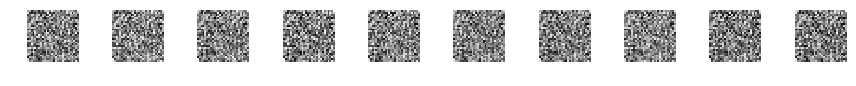

0 fake rate: 0.487819698277414


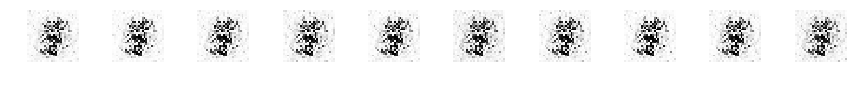

0 fake rate: 0.4102699590509369


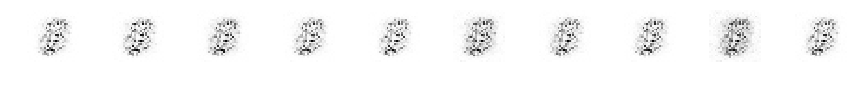

1 fake rate: 0.27328075621788356


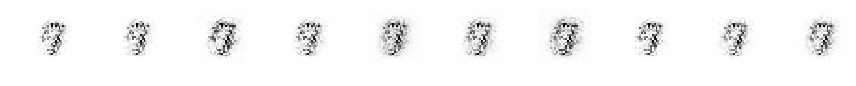

1 fake rate: 0.30947733311430303


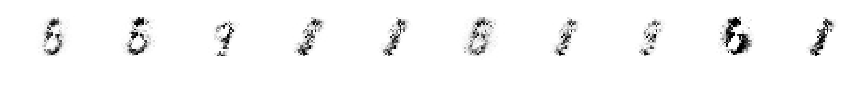

2 fake rate: 0.19646885289893767


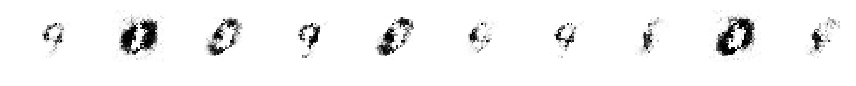

2 fake rate: 0.24497796709549505


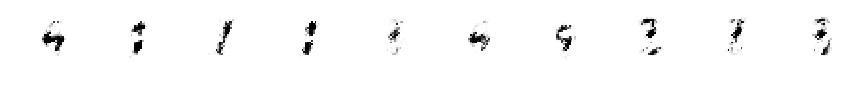

2 fake rate: 0.2889905871709573


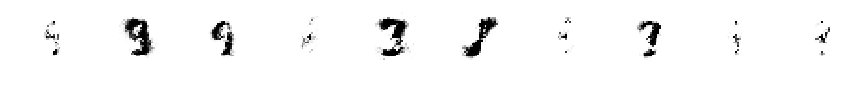

3 fake rate: 0.21425960437832328


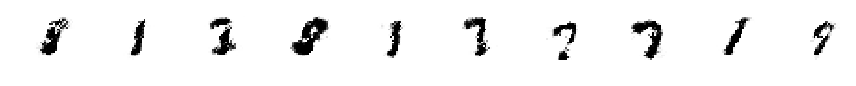

3 fake rate: 0.23291294900416526


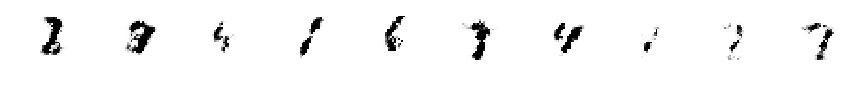

4 fake rate: 0.26610712917494844


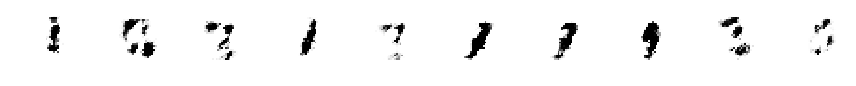

4 fake rate: 0.31312116470086765


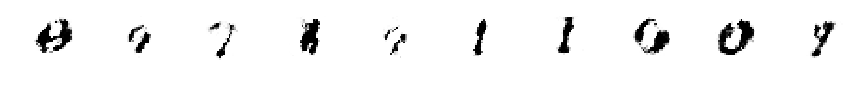

5 fake rate: 0.3378671904721062


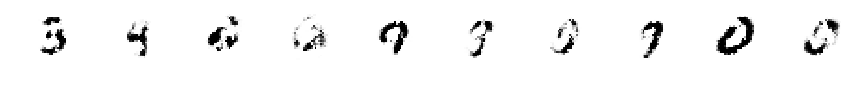

5 fake rate: 0.36141905683151887


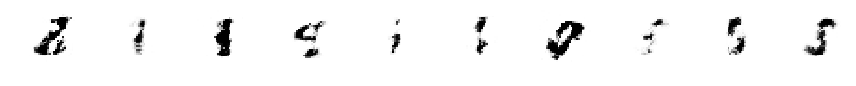

5 fake rate: 0.25233002809986477


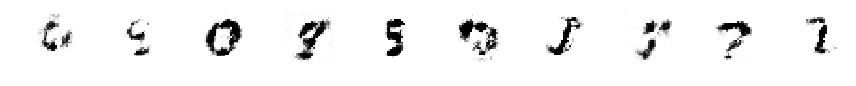

6 fake rate: 0.3332885853130428


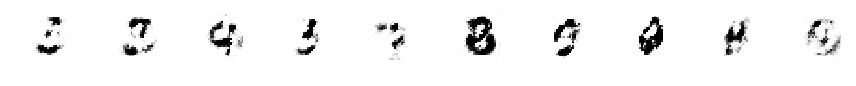

6 fake rate: 0.3295041260781147


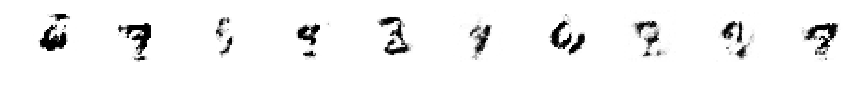

7 fake rate: 0.3257073452223737


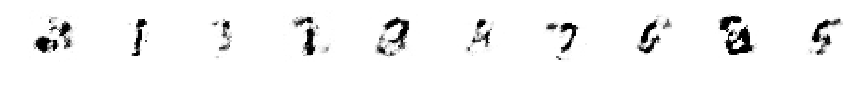

7 fake rate: 0.31486098260634643


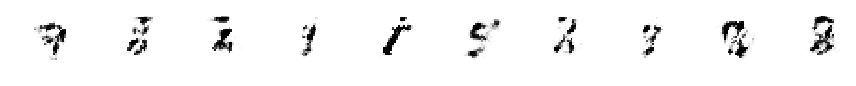

8 fake rate: 0.4091301328771926


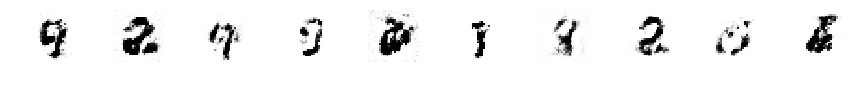

8 fake rate: 0.33430877568761985


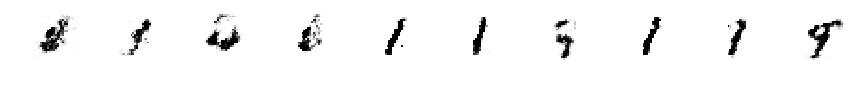

8 fake rate: 0.3868208712355191


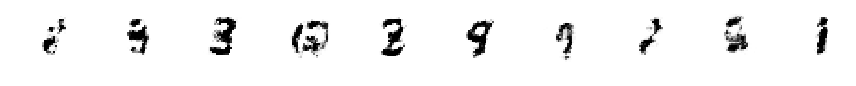

9 fake rate: 0.3517781842142307


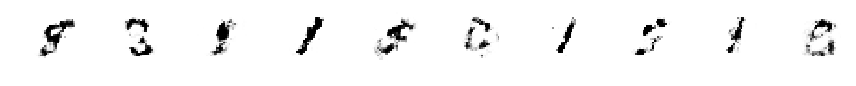

9 fake rate: 0.38096191749472336


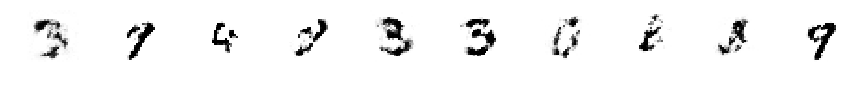

10 fake rate: 0.3796294105597448


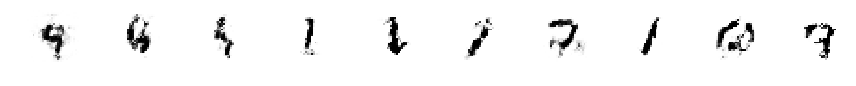

10 fake rate: 0.31605428290052096


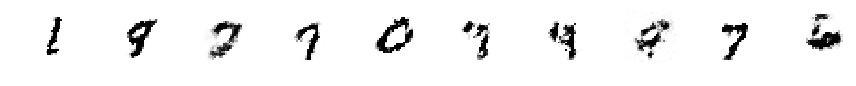

11 fake rate: 0.36115697142030545


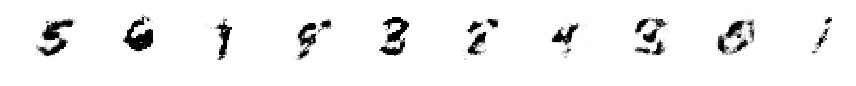

11 fake rate: 0.4050367270645898


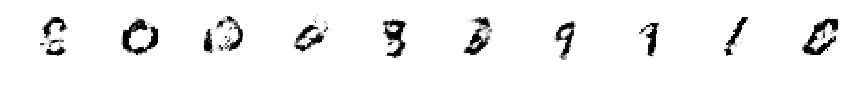

11 fake rate: 0.3843469235769288


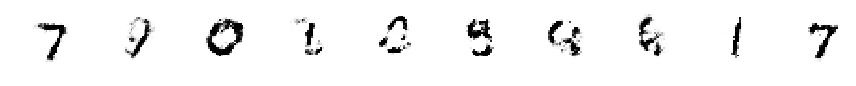

12 fake rate: 0.3585533049543711


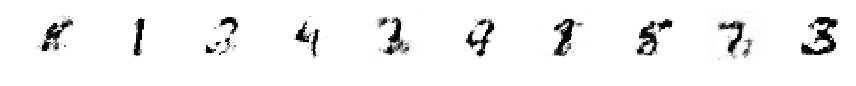

12 fake rate: 0.38770287563405703


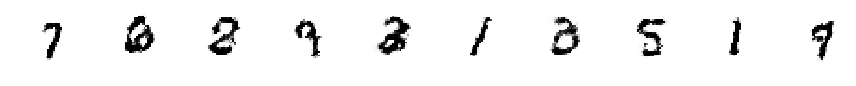

13 fake rate: 0.3791189011207721


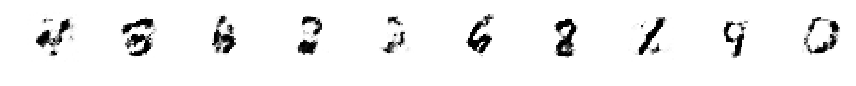

13 fake rate: 0.39340725873330634


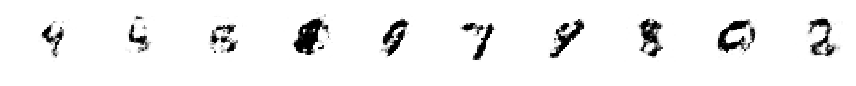

14 fake rate: 0.4119271296708883


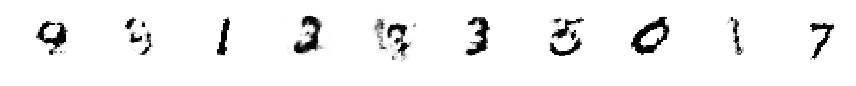

14 fake rate: 0.3497148121072363


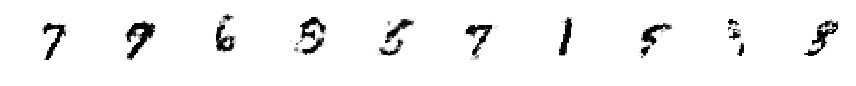

14 fake rate: 0.43436918185939366


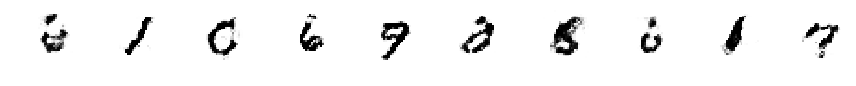

15 fake rate: 0.39845971062467095


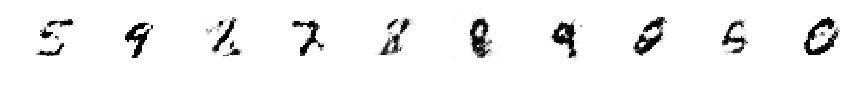

15 fake rate: 0.37154602294848704


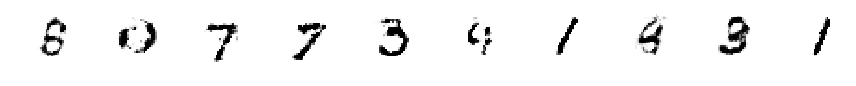

16 fake rate: 0.3961512139485136


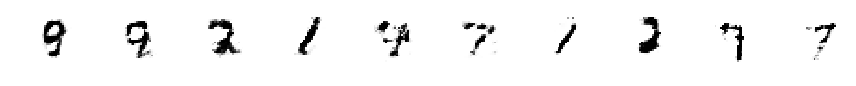

16 fake rate: 0.38286275279171483


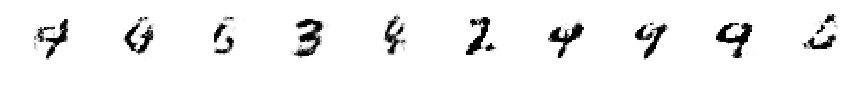

17 fake rate: 0.4051131412663548


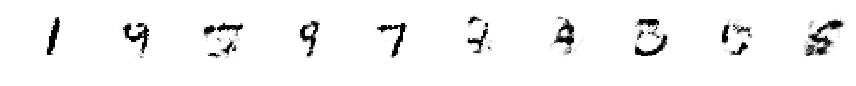

17 fake rate: 0.42149970316214364


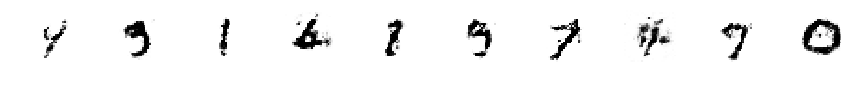

17 fake rate: 0.3655655233377452


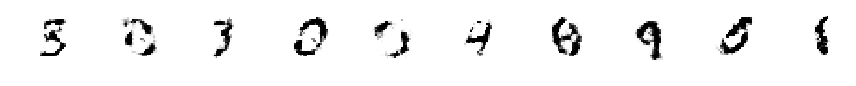

18 fake rate: 0.4181602483265148


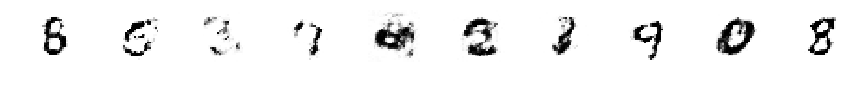

18 fake rate: 0.38761779569104415


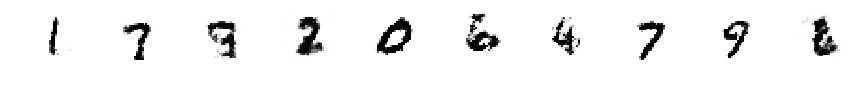

19 fake rate: 0.39371075484263657


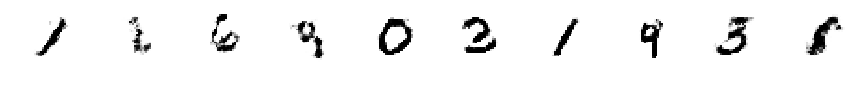

19 fake rate: 0.4194249351851764


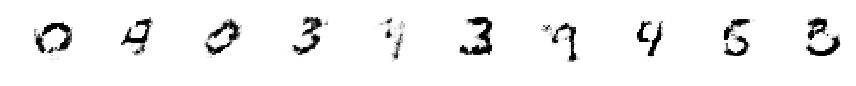

20 fake rate: 0.36422150680192183


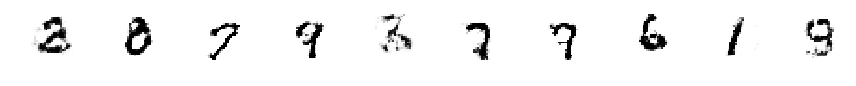

20 fake rate: 0.4377986975322734


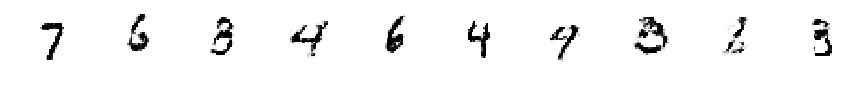

20 fake rate: 0.39557797027748015


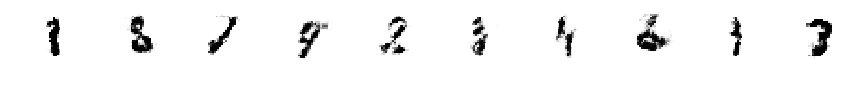

21 fake rate: 0.43808945295336443


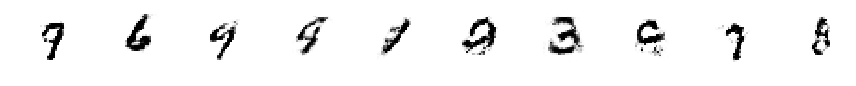

21 fake rate: 0.4080058483553177


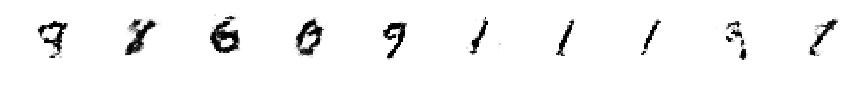

22 fake rate: 0.3862544235392953


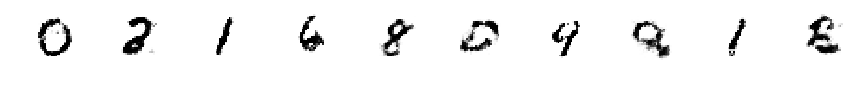

22 fake rate: 0.3854808004526993


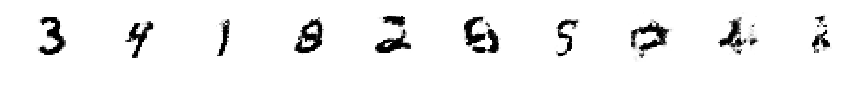

22 fake rate: 0.3876476938233802


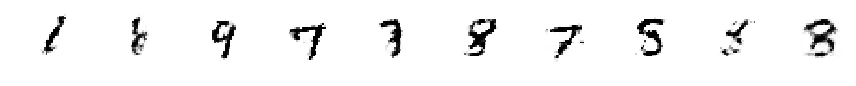

23 fake rate: 0.42234113391878775


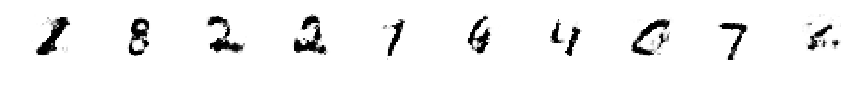

23 fake rate: 0.4076002021269263


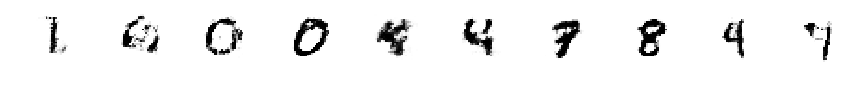

24 fake rate: 0.37953960475274107


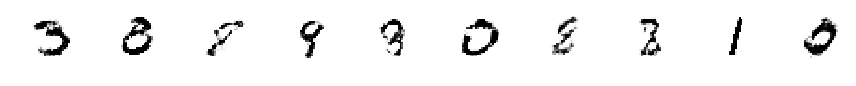

24 fake rate: 0.4476132140013925


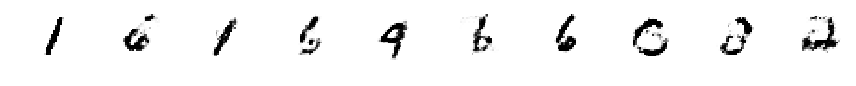

25 fake rate: 0.4036936899557511


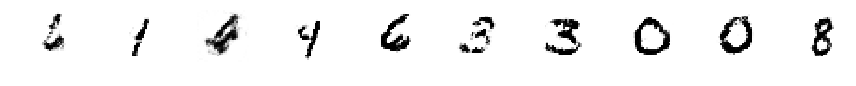

25 fake rate: 0.38423871131948867


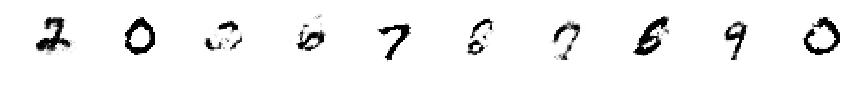

25 fake rate: 0.410603601877782


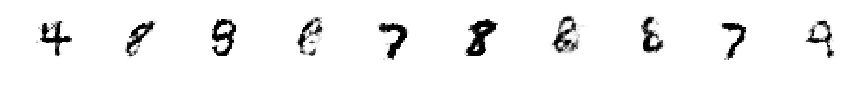

26 fake rate: 0.401607089113493


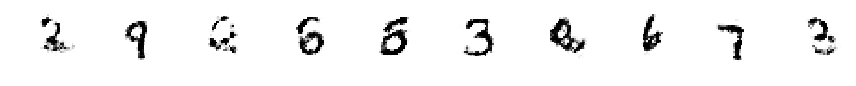

26 fake rate: 0.4106724525218895


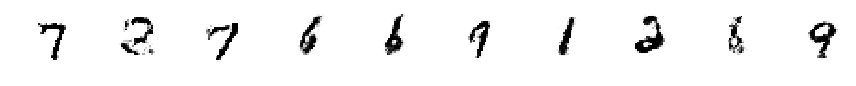

27 fake rate: 0.38178827797892984


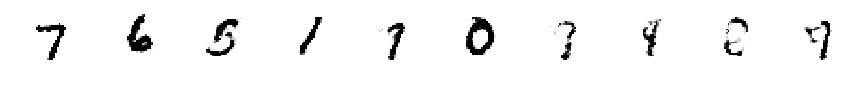

27 fake rate: 0.42206219840809117


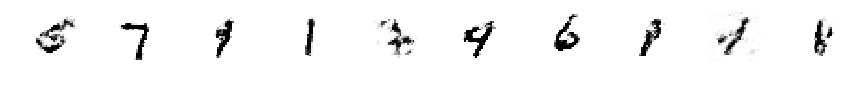

28 fake rate: 0.372860424743336


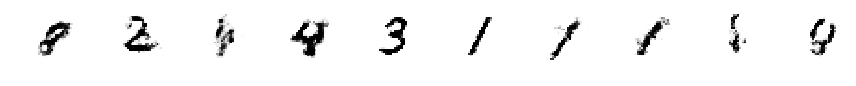

28 fake rate: 0.4249078138815116


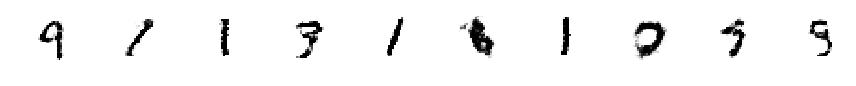

28 fake rate: 0.41590089948838826


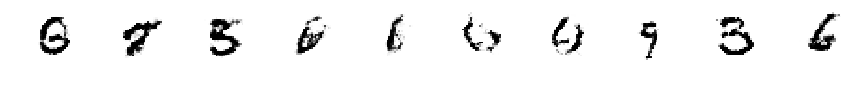

29 fake rate: 0.42115852878326393


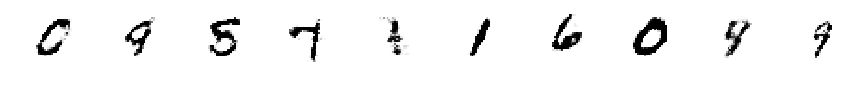

29 fake rate: 0.4340463385911797


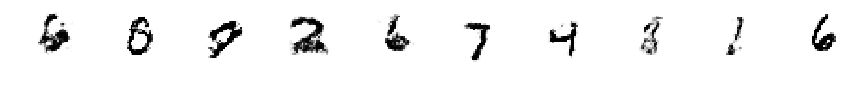

KeyboardInterrupt: ignored

In [ ]:
import sys
sys.path.append('..')

import os
import scipy.io as scio
import numpy as np
import theano
import theano.tensor as T
import lasagne
import h5py 
import shutil
import json
from keras.datasets import mnist
import matplotlib.pyplot as plt


from time import time
from PIL import Image

def load_data():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Preprocessing
    X_train = X_train.reshape(60000, 784)
    X_test = X_test.reshape(10000, 784)
    X_train = X_train.astype('float64')/255
    X_test = X_test.astype('float64')/255

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        Y_train=Y_train.astype('int64'),
        X_test = lasagne.utils.floatX(X_test),
        Y_test = Y_test.astype('int64'),)


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.
def create_G(loss_type=None, discriminator=None, lr=0.0002, b1=0.5, ngf=64): 
    noise = T.matrix('noise')
    generator =build_generator_32(noise,ngf=ngf)
    Tgimgs = lasagne.layers.get_output(generator)
    Tfake_out = lasagne.layers.get_output(discriminator, Tgimgs)
    
    if loss_type == 'trickLogD':
        generator_loss = lasagne.objectives.binary_crossentropy(Tfake_out, 1).mean()
    elif loss_type == 'minimax': 
        generator_loss = -lasagne.objectives.binary_crossentropy(Tfake_out, 0).mean()
    elif loss_type == 'ls': 
        generator_loss = T.mean(T.sqr((Tfake_out - 1)))
    
    generator_params = lasagne.layers.get_all_params(generator, trainable=True)
    updates_g = lasagne.updates.adam(generator_loss, generator_params, learning_rate=lr, beta1=b1)
    train_g = theano.function([noise],
                              generator_loss,
                              updates=updates_g)
    gen_fn = theano.function([noise],
                             lasagne.layers.get_output(generator,
                             deterministic=True))
    return train_g, gen_fn, generator 

def main():
    # Parameters
    task = 'mnist'
    name = '0'

    begin_save = 0 
    input_nc = 3 
    loss_type = ['trickLogD','minimax','ls'] 
    nloss = 3
    shuffle_ = True 
    batchSize = 32
    #fineSize = 32 
    flip = True

    ncandi = 1         # # of survived childern 
    kD = 8            # # of discrim updates for each gen update
    kG = 1             # # of discrim updates for each gen update
    #ntf = 256 
    ntf = batchSize*kD
    b1 = 0.5           # momentum term of adam
    nz = 100           # # of dim for Z
    ngf = 256          # # of gen filters in first conv layer
    ndf = 1024          # # of discrim filters in first conv layer
    niter = 100        # # of iter at starting learning rate
    lr = 0.0002        # initial learning rate for adam G
    lrd = 0.0002       # initial learning rate for adam D
    beta = 0.002       # hyperparameter of fitness function
    GP_norm = True     # wheather apply gradients penatly on discriminator  
    LAMBDA = 2.        # hyperparameter of GP term 
    
    save_freq = 100
    show_freq = 100

    # Load the dataset
    print("Loading data...")
    data = load_data()
    X_train = data['X_train']
            
    ################## MODEL D #######################
    print("Building model and compiling functions...")
    # Prepare Theano variables for inputs and targets
    real_imgs = T.matrix('real_imgs')
    fake_imgs = T.matrix('fake_imgs')
    # Create neural network model
    discriminator = build_discriminator_32(ndf=ndf)
    # Create expression for passing real data through the discriminator
    real_out = lasagne.layers.get_output(discriminator, real_imgs)
    # Create expression for passing fake data through the discriminator
    fake_out = lasagne.layers.get_output(discriminator, fake_imgs)
    # Create loss expressions
    discriminator_loss = (lasagne.objectives.binary_crossentropy(real_out, 1)
            + lasagne.objectives.binary_crossentropy(fake_out, 0)).mean()
 
    # Gradients penalty norm 
    if GP_norm is True:
        alpha = t_rng.uniform((batchSize, 1), low=0.,high=1.)  
        differences = fake_imgs - real_imgs
        interpolates = real_imgs + (alpha*differences)
        gradients = theano.grad(lasagne.layers.get_output(discriminator, interpolates).sum(), wrt=interpolates)
        slopes = T.sqrt(T.sum(T.sqr(gradients)))
        gradient_penalty = T.mean((slopes-1.)**2)
 
        D_loss = discriminator_loss +  LAMBDA*gradient_penalty
        b1_d = 0. 
    else:
        D_loss = discriminator_loss 
        b1_d = b1 
    
    # Create update expressions for training
    discriminator_params = lasagne.layers.get_all_params(discriminator, trainable=True)
    lrtd = theano.shared(lasagne.utils.floatX(lrd))
    updates_d = lasagne.updates.adam(
            D_loss, discriminator_params, learning_rate=lrtd, beta1=b1_d)
    lrt = theano.shared(lasagne.utils.floatX(lr))
    
    # Diversity fitness 
    Fd = theano.gradient.grad(discriminator_loss, discriminator_params) 
    Fd_score  = beta*T.log(sum(T.sum(T.sqr(x)) for x in Fd))
    
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_d = theano.function([real_imgs, fake_imgs],
                               discriminator_loss,
                               updates=updates_d)
    
    # Compile another function generating some data
    disft_fn = theano.function([real_imgs,fake_imgs],
                               [(real_out).mean(),
                                (fake_out).mean(),
                                Fd_score])
 
    # Launch the training loop.
    print("Starting training...") 
    desc = task + '_' + name 
    print desc
    
    if not os.path.isdir('logs'):
        os.mkdir(os.path.join('logs'))
    f_log = open('logs/%s.ndjson'%desc, 'wb')
    if not os.path.isdir('samples'):
        os.mkdir(os.path.join('samples/'))
    if not os.path.isdir('samples/'+desc):
        os.mkdir(os.path.join('samples/',desc))
    if not os.path.isdir('models'):
        os.mkdir(os.path.join('models/'))
    if not os.path.isdir('models/'+desc):
        os.mkdir(os.path.join('models/',desc))
     
    gen_new_params = []
    n_updates = 0
     
    # We iterate over epochs:
    for epoch in range(niter):
      if shuffle_ is True:
          #X_train = shuffle(X_train) 
          np.random.shuffle(X_train)
      for xmb in iter_data(X_train, size=batchSize*kD):
            # For measure fitness score 

            # get samples
            sample_xmb = floatX(X_train[np_rng.randint(0,50000,ncandi*ntf),:])
     
            # initial G cluster 
            if epoch + n_updates == 0:
                for can_i in range(0,ncandi): 
                    train_g_, gen_fn_, generator_ = create_G(
                            loss_type=loss_type[can_i%nloss],
                            discriminator=discriminator, lr=lr, b1=b1, ngf=ngf) 
 
                    for _ in range(0,kG):
                        zmb = floatX(np_rng.uniform(0., 1., size=(batchSize, nz)))
                        cost = train_g_(zmb)
 
                    sample_zmb = floatX(np_rng.uniform(0., 1., size=(ntf, nz)))
                    gen_imgs = gen_fn_(sample_zmb)
 
                    gen_new_params.append(lasagne.layers.get_all_param_values(generator_)) 
                    
                    if can_i == 0: 
                        g_imgs_old=gen_imgs
                        fmb = gen_imgs[0:batchSize/ncandi*kD,:]
                    else: 
                        g_imgs_old = np.append(g_imgs_old,gen_imgs,axis=0)
                        fmb = np.append(fmb,gen_imgs[0:batchSize/ncandi*kD,:],axis=0)
                    
                ######## MODEL G ########
                noise = T.matrix('noise')
                generator = build_generator_32(noise,ngf=ngf)
                Tgimgs = lasagne.layers.get_output(generator)
                Tfake_out = lasagne.layers.get_output(discriminator, Tgimgs)

                g_loss_logD = lasagne.objectives.binary_crossentropy(Tfake_out, 1).mean()
                g_loss_minimax = -lasagne.objectives.binary_crossentropy(Tfake_out, 0).mean()
                g_loss_ls = T.mean(T.sqr((Tfake_out - 1)))

                g_params = lasagne.layers.get_all_params(generator, trainable=True)

                up_g_logD = lasagne.updates.adam(g_loss_logD, g_params, learning_rate=lrt, beta1=b1)
                up_g_minimax = lasagne.updates.adam(g_loss_minimax, g_params, learning_rate=lrt, beta1=b1)
                up_g_ls = lasagne.updates.adam(g_loss_ls, g_params, learning_rate=lrt, beta1=b1)

                train_g_logD = theano.function([noise],g_loss_logD,updates=up_g_logD)
                train_g_minimax = theano.function([noise],g_loss_minimax,updates=up_g_minimax)
                train_g_ls = theano.function([noise],g_loss_ls,updates=up_g_ls)

                gen_fn = theano.function([noise], lasagne.layers.get_output(
                                        generator,deterministic=True))
            else:
                gen_old_params = gen_new_params
                for can_i in range(0,ncandi):
                    for type_i in range(0,nloss):
                        lasagne.layers.set_all_param_values(generator, gen_old_params[can_i])
                        if loss_type[type_i] == 'trickLogD':
                            for _ in range(0,kG):
                                zmb = floatX(np_rng.uniform(0., 1., size=(batchSize, nz)))
                                cost = train_g_logD(zmb)
                        elif loss_type[type_i] == 'minimax': 
                            for _ in range(0,kG):
                                zmb = floatX(np_rng.uniform(0., 1., size=(batchSize, nz)))
                                cost = train_g_minimax(zmb)
                        elif loss_type[type_i] == 'ls': 
                            for _ in range(0,kG):
                                zmb = floatX(np_rng.uniform(0., 1., size=(batchSize, nz)))
                                cost = train_g_ls(zmb)

                        sample_zmb = floatX(np_rng.uniform(0., 1., size=(ntf, nz)))
                        gen_imgs = gen_fn(sample_zmb)
                        _, fr_score, fd_score = disft_fn(sample_xmb[0:ntf],gen_imgs)
                        fit = fr_score - fd_score 
                     
                        if can_i*nloss + type_i < ncandi: 
                            idx = can_i*nloss + type_i
                            gen_new_params[idx]=lasagne.layers.get_all_param_values(generator)
                            fitness[idx]=fit
                            fake_rate[idx]=fr_score
                            g_imgs_old[idx*ntf:(idx+1)*ntf,:]=gen_imgs
                            fmb[idx*batchSize/ncandi*kD:(idx+1)*batchSize/ncandi*kD,:] = gen_imgs[0:batchSize/ncandi*kD,:]
                        else: 
                            fit_com = fitness - fit
                            if min(fit_com) < 0:
                                ids_replace = np.where(fit_com==min(fit_com))
                                idr = ids_replace[0][0]
                                fitness[idr]=fit
                                fake_rate[idr]=fr_score

                                gen_new_params[idr] = lasagne.layers.get_all_param_values(generator)

                                g_imgs_old[idr*ntf:(idr+1)*ntf,:]=gen_imgs
                                fmb[idr*batchSize/ncandi*kD:(idr+1)*batchSize/ncandi*kD,:] = gen_imgs[0:batchSize/ncandi*kD,:]

                f_log.write(str(fake_rate) + ' '+str(fd_score) +' ' + str(fitness)+ '\n')

            for xreal,xfake in iter_data(xmb, shuffle(fmb), size=batchSize):
                cost = train_d(xreal, xfake)

            for i in range(0, ncandi):
                xfake = g_imgs_old[i*ntf:(i+1)*ntf,:]
                xreal = sample_xmb[i*ntf:(i+1)*ntf,:]
                tr, fr, fd = disft_fn(xreal,xfake)
                if i == 0:
                    fake_rate = np.array([fr])
                    fitness = np.array([0.])
                    real_rate = np.array([tr])
                    FDL = np.array([fd])
                    
                else:
                    fake_rate = np.append(fake_rate,fr)
                    fitness = np.append(fitness,[0.])
                    real_rate = np.append(real_rate,tr)
                    FDL = np.append(FDL,fd)
            f_log.write(str(fake_rate)+' '+str(FDL)+'\n'+ \
                        str(epoch)+' '+str(n_updates)+' '+str(real_rate.mean())+'\n')
            f_log.flush()

            if n_updates % show_freq == 0:
                plot_generated(g_imgs_old, n_updates/save_freq)

            if n_updates%save_freq == 0 and n_updates > begin_save - 1:
            # Optionally, you could now dump the network weights to a file like this:
                np.savez('models/%s/gen_%d.npz'%(desc,n_updates/save_freq), *lasagne.layers.get_all_param_values(generator))
                np.savez('models/%s/dis_%d.npz'%(desc,n_updates/save_freq), *lasagne.layers.get_all_param_values(discriminator))

            n_updates += 1

if __name__ == '__main__':
    main()